<a href="https://colab.research.google.com/github/ndsoi/ndsoi/blob/main/%E6%96%B0%E9%97%BB%E5%88%86%E7%B1%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

做新闻分类器
<br>是一个单标签多分类问题（有多个主题类别，但每个新闻只属于一个主题，互斥的）


步骤1：加载数据集，与imdb一样内置在keras中了，同样需要过滤低频词

In [19]:
from tensorflow.keras.datasets import reuters
(train_data,train_labels),(test_data,test_labels) = reuters.load_data(num_words=10000)

查看一下数据集的内容<br>
数据和标签的形式<br>
数据的原文显示<br>

In [20]:
print(train_data.shape)
print(train_labels)

print(train_data[0])
print(train_labels[0])

# 尝试翻译原文
word_index = reuters.get_word_index()

index_to_word = dict([(value,key) for key,value in word_index.items()])  # 直接items()
decode_first_new = " ".join(index_to_word.get(i-3,"?") for i in train_data[0])

print(decode_first_new)

(8982,)
[ 3  4  3 ... 25  3 25]
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3
? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


步骤2：预处理数据集<br>
具体来说还是把数据输入和标签向量化<br>
data的向量化和前文一致，采用multi-hot的方式<br>
labels(标签)的向量化则可以采用one-hot的方式或是整数标量的方式<br>
采用one-hot则损失应该使用分类交叉熵、采用整数标量，则损失最好采用稀疏分类交叉熵

In [21]:
import numpy as np
def vectoraize_sequences(sequences,dimension=10000):
  results = np.zeros((len(sequences),dimension))
  for i,sequence in enumerate(sequences):
    for j in sequence:
      results[i,j] = 1
  return results

# 先采用one-hot的方式
def vectoraize_labels1(labels,classnum=46):
  results = np.zeros((len(labels),classnum))
  for i in range(len(labels)):
    results[i,labels[i]] = 1
  return results


vec_train_data = vectoraize_sequences(train_data)
vec_train_labels = vectoraize_labels1(train_labels)

vec_test_data = vectoraize_sequences(test_data)
vec_test_labels = vectoraize_labels1(test_labels)

print(vec_train_data)
print(vec_train_labels)




[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


步骤2.2 划分验证集

In [26]:
vec_val_data = vec_train_data[:1000]
vec_val_labels = vec_train_labels[:1000]

vec_train_data2 = vec_train_data[1000:]
vec_train_labels2 = vec_train_labels[1000:]



步骤3：定义模型<br>
1）因为是多分类问题，所以最后一层的激活函数应该为softmax<br>
2)因为采用的是multi-hot，还是适用Dense层的<br>
3)注意中间层的单元不要少于类别数目，否则可能导致信息丢失

In [27]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(units=64,activation="relu"),
    layers.Dense(units=64,activation="relu"),
    layers.Dense(units=46,activation="softmax")
])

model.compile(optimizer="rmsprop",loss="categorical_crossentropy",metrics=["accuracy"])
history = model.fit(vec_train_data2,vec_train_labels2,epochs=20,batch_size=512,validation_data=(vec_val_data,vec_val_labels))   # 漏了batch_size



Epoch 1/20
16/16 [==============================] - 2s 70ms/step - loss: 2.6412 - accuracy: 0.5035 - val_loss: 1.7600 - val_accuracy: 0.6320
Epoch 2/20
16/16 [==============================] - 1s 52ms/step - loss: 1.5067 - accuracy: 0.6909 - val_loss: 1.3672 - val_accuracy: 0.7160
Epoch 3/20
16/16 [==============================] - 1s 53ms/step - loss: 1.1723 - accuracy: 0.7533 - val_loss: 1.1936 - val_accuracy: 0.7390
Epoch 4/20
16/16 [==============================] - 1s 73ms/step - loss: 0.9580 - accuracy: 0.7935 - val_loss: 1.0824 - val_accuracy: 0.7790
Epoch 5/20
16/16 [==============================] - 1s 87ms/step - loss: 0.7939 - accuracy: 0.8292 - val_loss: 1.0287 - val_accuracy: 0.7780
Epoch 6/20
16/16 [==============================] - 1s 65ms/step - loss: 0.6622 - accuracy: 0.8614 - val_loss: 0.9748 - val_accuracy: 0.7870
Epoch 7/20
16/16 [==============================] - 1s 48ms/step - loss: 0.5494 - accuracy: 0.8880 - val_loss: 0.9152 - val_accuracy: 0.8030
Epoch 8/20
16

步骤4：绘制损失图

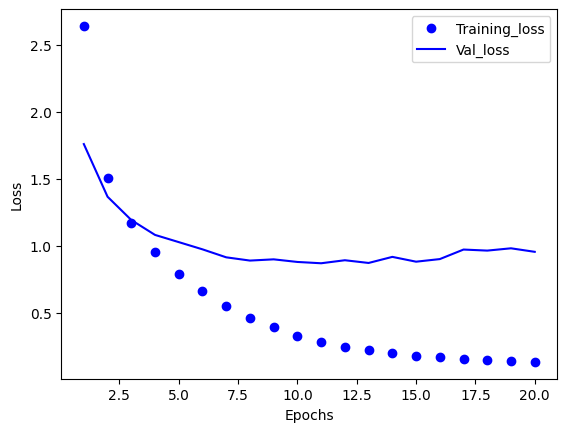

In [28]:
import matplotlib.pyplot as plt
history = history.history
train_loss = history['loss']
epochs = range(1,len(train_loss)+1)
plt.plot(epochs,train_loss,"bo",label="Training_loss")

val_loss = history['val_loss']
plt.plot(epochs,val_loss,"b",label="Val_loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()
plt.show()

步骤4.2 绘制精度图

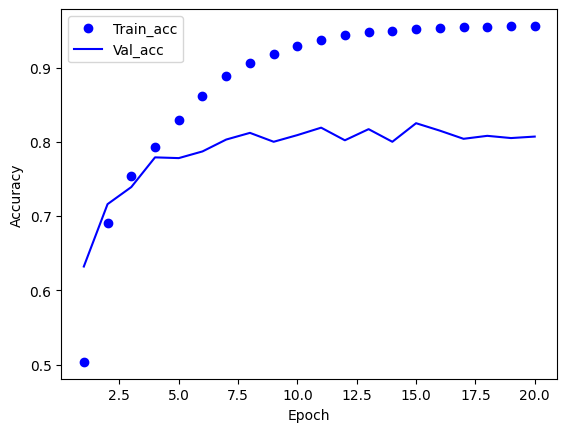

In [29]:
plt.clf()   # 清空图像
acc_train = history['accuracy']
plt.plot(epochs,acc_train,"bo",label="Train_acc")
acc_val = history['val_accuracy']
plt.plot(epochs,acc_val,"b",label="Val_acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

补一个原文翻译器

In [39]:
import random
def translate(index_to_word,data):
  decode_first_new = " ".join(index_to_word.get(i-3,"?") for i in data)
  return decode_first_new



可以看出当epochs=5左右的时候模型已经训练充分<br>
接下来进行模型的测试

In [43]:
predictions = model.predict(vec_test_data)

for i in range(len(predictions)):
  print(f"{i} 预测类别:{np.argmax(predictions[i])}")
  print(f"{i} 真实标签:{np.argmax(vec_test_labels[i])}")


71/71 [==============================] - 0s 3ms/step
0 预测类别:3
0 真实标签:3
1 预测类别:10
1 真实标签:10
2 预测类别:1
2 真实标签:1
3 预测类别:4
3 真实标签:4
4 预测类别:13
4 真实标签:4
5 预测类别:3
5 真实标签:3
6 预测类别:3
6 真实标签:3
7 预测类别:3
7 真实标签:3
8 预测类别:3
8 真实标签:3
9 预测类别:3
9 真实标签:3
10 预测类别:1
10 真实标签:5
11 预测类别:4
11 真实标签:4
12 预测类别:1
12 真实标签:1
13 预测类别:3
13 真实标签:3
14 预测类别:1
14 真实标签:1
15 预测类别:11
15 真实标签:11
16 预测类别:4
16 真实标签:23
17 预测类别:3
17 真实标签:3
18 预测类别:19
18 真实标签:19
19 预测类别:3
19 真实标签:3
20 预测类别:8
20 真实标签:8
21 预测类别:3
21 真实标签:3
22 预测类别:3
22 真实标签:3
23 预测类别:3
23 真实标签:3
24 预测类别:9
24 真实标签:9
25 预测类别:3
25 真实标签:3
26 预测类别:4
26 真实标签:4
27 预测类别:6
27 真实标签:6
28 预测类别:10
28 真实标签:10
29 预测类别:3
29 真实标签:3
30 预测类别:3
30 真实标签:3
31 预测类别:10
31 真实标签:10
32 预测类别:4
32 真实标签:20
33 预测类别:3
33 真实标签:1
34 预测类别:19
34 真实标签:19
35 预测类别:4
35 真实标签:4
36 预测类别:19
36 真实标签:40
37 预测类别:1
37 真实标签:1
38 预测类别:4
38 真实标签:4
39 预测类别:3
39 真实标签:3
40 预测类别:3
40 真实标签:15
41 预测类别:21
41 真实标签:21
42 预测类别:3
42 真实标签:3
43 预测类别:34
43 真实标签:34
44 预测类别:4
44 真实标签:4
45 预测类别:4
45 真实标签:4
46 预测类别:3
46 真实标签:3
47 预测